In [33]:
import warnings

import pandas as pd
import numpy as np
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, recall_score, confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt

from shap import TreeExplainer

warnings.filterwarnings('ignore')

In [34]:
def individual_log_loss(y_true, y_pred, eps=1e-15):
    """Compute log-loss for each individual of the sample."""

    y_pred = np.clip(y_pred, eps, 1 - eps)
    return - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)


def shap_sum2proba(shap_sum):
    """Compute sigmoid function of the Shap sum to get predicted probability."""

    return 1 / (1 + np.exp(-shap_sum))


def get_preds_shaps(X_train, X_val, y_train, y_val, is_train=True):
    """Get predictions (predicted probabilities) and SHAP values for a dataset."""
    space = {
        'colsample_bytree': 0.8694668068945633,
        'gamma': 3.8273847579638383,
        'learning_rate': 0.24623006595084537,
        'max_depth': 7,
        'min_child_weight': 3.5682287335539407,
        'reg_alpha': 2.338903756626607,
        'reg_lambda': 8.134971922940249,
        'subsample': 0.5003470732993074
    }
    f1, model = evaluate_model_opt(X_train, X_val, y_train, y_val, space)

    X = None
    y = None

    if is_train == True:
        X = X_train.copy()
    else:
        X = X_val.copy()

    preds = pd.Series(model.predict_proba(X)[:, 1], index=X.index)
    shap_explainer = TreeExplainer(model)

    shap_values = shap_explainer.shap_values(X)
    shap_expected_value = shap_explainer.expected_value

    shaps = pd.DataFrame(
        data=shap_values,
        index=X.index,
        columns=X.columns)
    return preds, shaps, shap_expected_value


def get_feature_contributions(y_true, y_pred, shap_values, shap_expected_value):
    """Compute prediction contribution and error contribution for each feature."""

    prediction_contribution = shap_values.abs().mean().rename("prediction_contribution")

    ind_log_loss = individual_log_loss(y_true=y_true['result_match'], y_pred=y_pred).rename("log_loss")
    y_pred_wo_feature = shap_values.apply(lambda feature: shap_expected_value + shap_values.sum(axis=1) - feature).applymap(shap_sum2proba)
    ind_log_loss_wo_feature = y_pred_wo_feature.apply(lambda feature: individual_log_loss(y_true=y_true['result_match'], y_pred=feature))
    ind_log_loss_diff = ind_log_loss_wo_feature.apply(lambda feature: ind_log_loss - feature)
    error_contribution = ind_log_loss_diff.mean().rename("error_contribution").T

    return prediction_contribution, error_contribution

In [35]:
def evaluate_model_opt(X_train, X_val, y_train, y_val, space):
    model = XGBClassifier( random_state=42, enable_categorical=True, scale_pos_weight=2)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0, early_stopping_rounds=25)
    y_pred = model.predict(X_val)

    return f1_score(y_val, y_pred), model

In [36]:
X = pd.read_csv('../data/new_features/df_.csv')
y = pd.read_csv('../data/new_features/y.csv')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
space = {
    'colsample_bytree': 0.8694668068945633,
    'gamma': 3.8273847579638383,
    'learning_rate': 0.24623006595084537,
    'max_depth': 7,
    'min_child_weight': 3.5682287335539407,
    'reg_alpha': 2.338903756626607,
    'reg_lambda': 8.134971922940249,
    'subsample': 0.5003470732993074
}

f1, xgb_model = evaluate_model_opt(X_train, X_val, y_train, y_val, space)

f1

0.6385542168674698

In [38]:
from shap import TreeExplainer

shap_explainer = TreeExplainer(xgb_model)
shap_values = shap_explainer.shap_values(X_train)

In [39]:
preds_train, shaps_train, shap_expected_value_train = get_preds_shaps(X_train, X_val, y_train, y_val, True)
preds_val, shaps_val, shap_expected_value_val = get_preds_shaps(X_train, X_val, y_train, y_val, False)

In [40]:
# assert ((preds_train - (shap_expected_value_train + shaps_train.sum(axis=1)).apply(shap_sum2proba)).abs() < 1e-10).all()
# assert ((preds_val - (shap_expected_value_val + shaps_val.sum(axis=1)).apply(shap_sum2proba)).abs() < 1e-10).all()

In [41]:
prediction_contribution_trn, error_contribution_trn = get_feature_contributions(
    y_true=y_train,
    y_pred=preds_train,
    shap_values=shaps_train,
    shap_expected_value=shap_expected_value_train
)

prediction_contribution_val, error_contribution_val = get_feature_contributions(
    y_true=y_val,
    y_pred=preds_val,
    shap_values=shaps_val,
    shap_expected_value=shap_expected_value_val
)

contributions_trn = pd.concat([prediction_contribution_trn, error_contribution_trn], axis=1)
contributions_val = pd.concat([prediction_contribution_val, error_contribution_val], axis=1)

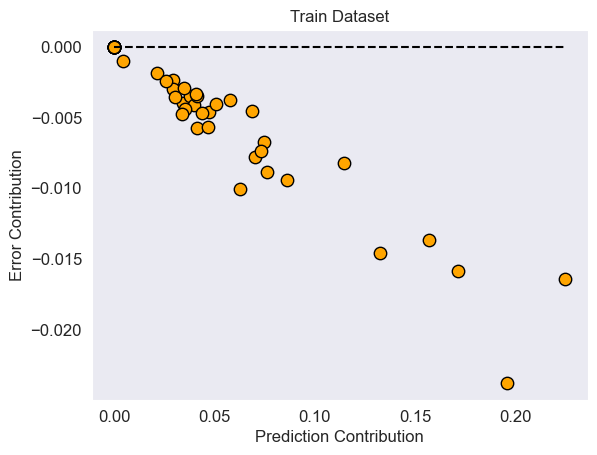

In [42]:
fig, ax = plt.subplots()

ax.scatter(contributions_trn["prediction_contribution"], contributions_trn["error_contribution"], s=80, color="orange", edgecolors="black")
ax.hlines(y=0, xmin=0, xmax=contributions_trn["prediction_contribution"].max(), ls="--", color="black")
ax.tick_params(axis="both", which="major", labelsize=12)
ax.grid();
ax.set_axisbelow(True)
ax.set_title("Train Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

fig.savefig("single_trn.png", dpi=200, bbox_inches="tight")

In [43]:
pd.set_option("display.max_rows", 10)
contributions_trn.sort_values("prediction_contribution", ascending=False).head(10)

,prediction_contribution,error_contribution
avg_away_rating_attack,0.224789,-0.016442
ewm_shoton_home,0.195654,-0.023777
avg_home_rating_attack,0.171202,-0.015866
ewm_shoton_away,0.156927,-0.013689
avg_home_team_rating,0.132522,-0.014604
points_home,0.114416,-0.008234
ewm_possession_away,0.086272,-0.009430
player_rating_away_player_8,0.076077,-0.008831
ewm_away_team_goals,0.074741,-0.006759
home_streak_wins,0.073345,-0.007370


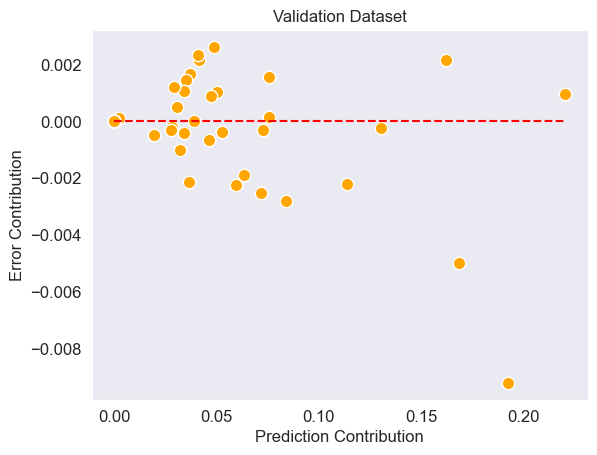

In [44]:
fig, ax = plt.subplots()

ax.scatter(contributions_val["prediction_contribution"], contributions_val["error_contribution"], s=80, color="orange", edgecolors="white")
ax.hlines(y=0, xmin=0, xmax=contributions_val["prediction_contribution"].max(), ls="--", color="red")
ax.tick_params(axis="both", which="major", labelsize=12)

ax.grid()
ax.set_axisbelow(True)
ax.set_title("Validation Dataset", fontsize=12)
ax.set_xlabel("Prediction Contribution", fontsize=12)
ax.set_ylabel("Error Contribution", fontsize=12)

fig.savefig("single_val.png", dpi=200, bbox_inches="tight")

In [45]:
pd.set_option("display.max_rows", 10)

contributions_val.sort_values("error_contribution", ascending=True).round(4).head(10)

,prediction_contribution,error_contribution
ewm_shoton_home,0.1927,-0.0092
avg_home_rating_attack,0.1686,-0.0050
ewm_possession_away,0.0841,-0.0028
home_weighted_wins,0.0720,-0.0025
away_streak_wins,0.0594,-0.0023
points_home,0.1136,-0.0022
player_rating_home_player_7,0.0364,-0.0021
home_streak_wins,0.0634,-0.0019
player_rating_away_player_7,0.0323,-0.0010
points_away,0.0463,-0.0007


In [46]:
from tqdm import tqdm
from sklearn.metrics import log_loss, average_precision_score

features = X_train.columns.to_list()
rfe_error = pd.DataFrame(dtype=float)
features_curr = features.copy()
feature_drop = None

for iteration in tqdm(range(len(features))):
    preds_val, shaps_val, shap_expected_value_val = get_preds_shaps(X_train[features_curr], X_val[features_curr], y_train, y_val, False)

    prediction_contribution_val, error_contribution_val = get_feature_contributions(
        y_true=y_val,
        y_pred=preds_val,
        shap_values=shaps_val,
        shap_expected_value=shap_expected_value_val
    )

    rfe_error.loc[iteration, "feature_drop"] = feature_drop
    rfe_error.loc[iteration, "n_features"] = len(features_curr)
    rfe_error.loc[iteration, "contrib"] = error_contribution_val.max()

    rfe_error.loc[iteration, "logloss_trn"] = log_loss(y_train['result_match'], preds_train)
    rfe_error.loc[iteration, "logloss_val"] = log_loss(y_val['result_match'], preds_val)
    # rfe_error.loc[iteration, "logloss_tst"] = log_loss(df.loc[ix_tst, target], preds.loc[ix_tst])

    rfe_error.loc[iteration, "ap_trn"] = average_precision_score(y_train['result_match'], preds_train, average='weighted')
    rfe_error.loc[iteration, "ap_val"] = average_precision_score(y_val['result_match'], preds_val, average='weighted')
    # rfe_error.loc[iteration, "ap_tst"] = average_precision_score(df.loc[ix_tst, target], preds.loc[ix_tst])

    # rfe_error.loc[iteration, "f1_trn"] = f1_score(y_train['result_match'], preds_train, average='binary', pos_label='binary')
    # rfe_error.loc[iteration, "f1_val"] = f1_score(y_val['result_match'], preds_val, average='binary', pos_label='binary')
    # rfe_error.loc[iteration, "f1_tst"] = f1_score(df.loc[ix_tst, target], preds.loc[ix_tst])

    feature_drop = error_contribution_val.idxmax()

    features_curr.remove(feature_drop)

100%|██████████| 47/47 [00:09<00:00,  5.08it/s]


In [47]:
features = X_train.columns.to_list()
rfe_prediction = pd.DataFrame(dtype=float)
features_curr = features.copy()
feature_drop = None

for iteration in tqdm(range(len(features))):
    preds_val, shaps_val, shap_expected_value_val = get_preds_shaps(X_train[features_curr], X_val[features_curr], y_train, y_val, False)

    prediction_contribution_val, error_contribution_val = get_feature_contributions(
        y_true=y_val,
        y_pred=preds_val,
        shap_values=shaps_val,
        shap_expected_value=shap_expected_value_val
    )

    rfe_prediction.loc[iteration, "feature_drop"] = feature_drop
    rfe_prediction.loc[iteration, "n_features"] = len(features_curr)
    rfe_prediction.loc[iteration, "contrib"] = prediction_contribution_val.max()

    rfe_prediction.loc[iteration, "logloss_trn"] = log_loss(y_train['result_match'], preds_train)
    rfe_prediction.loc[iteration, "logloss_val"] = log_loss(y_val['result_match'], preds_val)
    # rfe_prediction.loc[iteration, "logloss_tst"] = log_loss(df.loc[ix_tst, target], preds.loc[ix_tst])
    rfe_prediction.loc[iteration, "ap_trn"] = average_precision_score(y_train['result_match'], preds_train)
    rfe_prediction.loc[iteration, "ap_val"] = average_precision_score(y_val['result_match'], preds_val)
    # rfe_prediction.loc[iteration, "ap_tst"] = average_precision_score(df.loc[ix_tst, target], preds.loc[ix_tst])

    # rfe_prediction.loc[iteration, "f1_trn"] = f1_score(y_train['result_match'], preds_train, average='weighted'))
    # rfe_prediction.loc[iteration, "f1_val"] = f1_score(y_val['result_match'], preds_val, average='weighted'))
    # rfe_prediction.loc[iteration, "f1_tst"] = f1_score(df.loc[ix_tst, target], preds.loc[ix_tst])

    feature_drop = prediction_contribution_val.idxmax()

    features_curr.remove(feature_drop)

100%|██████████| 47/47 [00:08<00:00,  5.53it/s]


In [48]:
max_iter_show = len(features) - 5

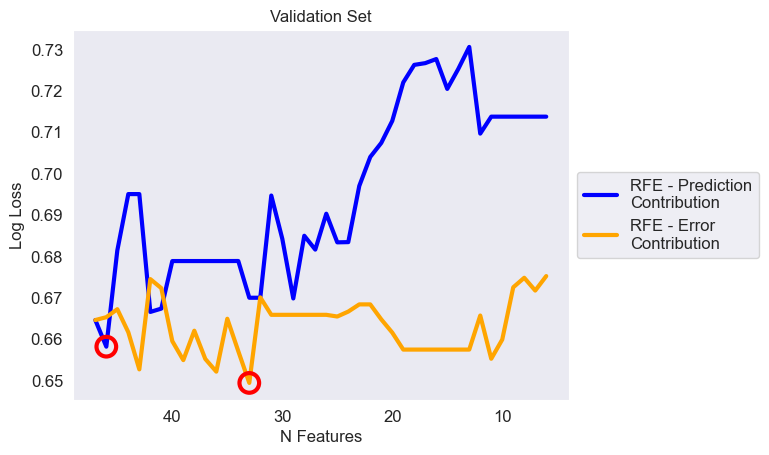

In [49]:
fig, ax = plt.subplots()

idxmin_prediction = rfe_prediction["logloss_val"].idxmin()
idxmin_error = rfe_error["logloss_val"].idxmin()

ax.plot(-rfe_prediction.head(max_iter_show)["n_features"], rfe_prediction.head(max_iter_show)["logloss_val"], lw=3, color="blue", label="RFE - Prediction\nContribution")
ax.plot(-rfe_error.head(max_iter_show)["n_features"], rfe_error.head(max_iter_show)["logloss_val"], lw=3, color="orange", label="RFE - Error\nContribution")
ax.scatter(-rfe_prediction.loc[idxmin_prediction, "n_features"], rfe_prediction.loc[idxmin_prediction, "logloss_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.scatter(-rfe_error.loc[idxmin_error, "n_features"], rfe_error.loc[idxmin_error, "logloss_val"], s=200, marker="o", facecolors="none", edgecolors="red", lw=3, zorder=100)
ax.set_title("Validation Set", fontsize=12)
ax.set_ylabel("Log Loss", fontsize=12)
ax.set_xlabel("N Features", fontsize=12)
ax.set_xticklabels([-int(x) for x in ax.get_xticks()])
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=12)

fig.savefig("rfe_logloss_val_.png", dpi=200, bbox_inches="tight")

In [50]:
rfe_error.sort_values("logloss_val", ascending=True).head(10)

,feature_drop,n_features,contrib,logloss_trn,logloss_val,ap_trn,ap_val
14,player_rating_away_player_10,33.0,2.400728e-03,0.433854,0.649435,0.934658,0.690797
11,player_rating_home_player_11,36.0,2.372050e-03,0.433854,0.652163,0.934658,0.672874
4,defensive_weakness_away,43.0,3.459613e-03,0.433854,0.652709,0.934658,0.682718
8,away_weighted_wins,39.0,1.394219e-03,0.433854,0.654946,0.934658,0.669730
10,avg_home_team_rating_x_ewm_shoton_away,37.0,2.369801e-03,0.433854,0.655223,0.934658,0.675752
36,ewm_possession_home,11.0,-2.394261e-04,0.433854,0.655271,0.934658,0.659173
13,player_rating_away_player_7,34.0,3.249709e-03,0.433854,0.657100,0.934658,0.681696
34,avg_away_rating_defence,13.0,-3.408621e-04,0.433854,0.657486,0.934658,0.685675
28,average_rating_home,19.0,2.816134e-10,0.433854,0.657486,0.934658,0.685675
31,player_rating_away_player_4,16.0,1.480285e-09,0.433854,0.657486,0.934658,0.685675


In [51]:
X

,player_rating_home_player_1,player_rating_home_player_2,player_rating_home_player_3,player_rating_home_player_4,player_rating_home_player_5,player_rating_home_player_6,player_rating_home_player_7,player_rating_home_player_8,player_rating_home_player_9,player_rating_home_player_10,...,ewm_possession_away,avg_home_rating_attack,avg_away_rating_attack,avg_away_rating_defence,avg_home_rating_defence,average_rating_home,average_rating_away,avg_home_team_rating_x_ewm_shoton_away,defensive_weakness_home,defensive_weakness_away
0,72,72,72,72,72,72,79,75,85,87,...,NaN,78.50,71.50,71.0,72.0,75.545455,71.272727,NaN,NaN,NaN
1,79,79,79,79,79,79,78,75,74,81,...,NaN,75.83,82.33,84.0,79.0,77.272727,83.090909,NaN,NaN,NaN
2,77,77,77,77,77,77,72,82,76,73,...,NaN,76.33,73.50,76.0,77.0,76.636364,74.636364,NaN,NaN,NaN
3,82,82,82,82,82,82,72,73,77,73,...,NaN,76.33,77.50,73.0,82.0,78.909091,75.454545,NaN,NaN,NaN
4,77,77,77,77,77,77,67,75,82,84,...,NaN,77.00,79.33,84.0,77.0,77.000000,81.454545,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,80,80,80,80,80,80,79,75,80,51,...,52.130,74.50,73.33,74.0,80.0,77.000000,73.636364,36.005200,3.012987,2.091358
3036,86,86,86,86,86,86,83,83,83,88,...,52.362,82.83,75.50,76.0,86.0,84.272727,75.727273,43.213656,2.017260,1.003601
3037,79,79,79,79,79,79,81,86,88,85,...,52.919,83.50,74.67,76.0,79.0,81.454545,75.272727,38.867940,1.129464,2.550725
3038,78,78,78,78,78,78,76,80,79,75,...,45.764,77.33,78.83,76.0,78.0,77.636364,77.545455,61.459824,1.017564,1.650645


In [52]:
# Initialize results DataFrame without the dataset_name
results = pd.DataFrame(columns=["feature_set", "len_set", "preds_corr_bs", "ap_from_shaps_bs", "ap_from_model_bs", "roc_from_shaps_bs", "roc_from_model_bs"])

feature_sets = []

# Generate random feature sets
for enum in range(50):
    row_id = "_" + str(enum+1).zfill(2)  # Simplified row_id, as we don't use dataset_name anymore
    while True:
        feature_set = sorted(np.random.choice(X_train.columns, replace=False, size=np.random.randint(1, len(X_train.columns))))
        if feature_set not in feature_sets:
            feature_sets.append(feature_set)
            results.loc[row_id, :] = feature_set, len(feature_set), [], [], [], [], []
            break

for bootstrap_iter in range(5):
    # Get predictions, SHAP values, and SHAP expected value
    preds, shaps, shaps_ev = get_preds_shaps(X_train, X_val, y_train, y_val, False)

    # Save results of the full model using a fixed identifier for the full feature set row
    full_model_row_id = "_00"
    if full_model_row_id not in results.index:
        results.loc[full_model_row_id, :] = sorted(X_train.columns), len(X_train.columns), [], [], [], [], []
    results.at[full_model_row_id, "ap_from_shaps_bs"].append(average_precision_score(y_val, preds))
    results.at[full_model_row_id, "ap_from_model_bs"].append(average_precision_score(y_val, preds))
    results.at[full_model_row_id, "roc_from_shaps_bs"].append(roc_auc_score(y_val, preds))
    results.at[full_model_row_id, "roc_from_model_bs"].append(roc_auc_score(y_val, preds))

    for enum, feature_set in enumerate(feature_sets):
        row_id = "_" + str(enum+1).zfill(2)

        # Compute predictions as estimated from the SHAP values
        preds_from_shaps = shap_sum2proba(shap_sum=shaps_ev + shaps[feature_set].sum(axis=1))

        # Get predictions from model trained on the feature set
        preds_from_model = pd.Series(
            XGBClassifier(**space, random_state=42, enable_categorical=True, scale_pos_weight=2).fit(X_train[feature_set], y_train).predict_proba(X_val[feature_set])[:, 1],
            index=X_val.index
        )

        results.at[row_id, "preds_corr_bs"].append(preds_from_shaps.corr(preds_from_model))
        results.at[row_id, "ap_from_shaps_bs"].append(average_precision_score(y_val, preds_from_shaps))
        results.at[row_id, "ap_from_model_bs"].append(average_precision_score(y_val, preds_from_model))
        results.at[row_id, "roc_from_shaps_bs"].append(roc_auc_score(y_val, preds_from_shaps))
        results.at[row_id, "roc_from_model_bs"].append(roc_auc_score(y_val, preds_from_model))

# Calculate mean values for bootstrap results
results["preds_corr"] = results["preds_corr_bs"].apply(np.mean)
results["ap_from_shaps"] = results["ap_from_shaps_bs"].apply(np.mean)
results["ap_from_model"] = results["ap_from_model_bs"].apply(np.mean)
results["roc_from_shaps"] = results["roc_from_shaps_bs"].apply(np.mean)
results["roc_from_model"] = results["roc_from_model_bs"].apply(np.mean)

In [53]:
results

,feature_set,len_set,preds_corr_bs,ap_from_shaps_bs,ap_from_model_bs,roc_from_shaps_bs,roc_from_model_bs,preds_corr,ap_from_shaps,ap_from_model,roc_from_shaps,roc_from_model
_01,"[avg_away_rating_attack, avg_away_team_rating,...",28,"[0.7744717850339389, 0.7744717850339389, 0.774...","[0.6663217491198311, 0.6663217491198311, 0.666...","[0.6651320921448307, 0.6651320921448307, 0.665...","[0.6970568999345977, 0.6970568999345977, 0.697...","[0.702757793764988, 0.702757793764988, 0.70275...",0.774472,0.666322,0.665132,0.697057,0.702758
_02,"[average_rating_away, avg_away_rating_attack, ...",37,"[0.7790189766948452, 0.7790189766948452, 0.779...","[0.6726743264885413, 0.6726743264885413, 0.672...","[0.6555569695108276, 0.6555569695108276, 0.655...","[0.7013843470678003, 0.7013843470678003, 0.701...","[0.6948005232177894, 0.6948005232177894, 0.694...",0.779019,0.672674,0.655557,0.701384,0.694801
_03,"[average_rating_away, avg_home_rating_attack, ...",15,"[0.7579112345469882, 0.7579112345469882, 0.757...","[0.6538630789308197, 0.6538630789308197, 0.653...","[0.669411219799077, 0.669411219799077, 0.66941...","[0.6845323741007194, 0.6845323741007194, 0.684...","[0.7104207543056464, 0.7104207543056464, 0.710...",0.757911,0.653863,0.669411,0.684532,0.710421
_04,"[average_rating_away, avg_away_team_rating, de...",13,"[0.5636005836750383, 0.5636005836750383, 0.563...","[0.6073192878064317, 0.6073192878064317, 0.607...","[0.6578534053834694, 0.6578534053834694, 0.657...","[0.6398190538478308, 0.6398190538478308, 0.639...","[0.7009701329845215, 0.7009701329845215, 0.700...",0.563601,0.607319,0.657853,0.639819,0.700970
_05,"[ewm_away_team_goals_conceded, ewm_shoton_home...",5,"[0.6108105839378888, 0.6108105839378888, 0.610...","[0.6005790715525358, 0.6005790715525358, 0.600...","[0.6549973806067977, 0.6549973806067977, 0.654...","[0.6394920427294528, 0.6394920427294528, 0.639...","[0.689513843470678, 0.689513843470678, 0.68951...",0.610811,0.600579,0.654997,0.639492,0.689514
...,...,...,...,...,...,...,...,...,...,...,...,...
_47,"[average_rating_away, avg_away_rating_attack, ...",19,"[0.7142324695980146, 0.7142324695980146, 0.714...","[0.6461976943844459, 0.6461976943844459, 0.646...","[0.6556734873191994, 0.6556734873191994, 0.655...","[0.6702092871157619, 0.6702092871157619, 0.670...","[0.6854153041203401, 0.6854153041203401, 0.685...",0.714232,0.646198,0.655673,0.670209,0.685415
_48,"[average_rating_away, avg_away_team_rating, av...",26,"[0.7050624170225992, 0.7050624170225992, 0.705...","[0.6677990773509143, 0.6677990773509143, 0.667...","[0.6649116747628858, 0.6649116747628858, 0.664...","[0.687573577501635, 0.687573577501635, 0.68757...","[0.6908109875735775, 0.6908109875735775, 0.690...",0.705062,0.667799,0.664912,0.687574,0.690811
_49,"[ewm_away_team_goals_conceded, home_streak_win...",5,"[0.1998656480127573, 0.1998656480127573, 0.199...","[0.48686882836542633, 0.48686882836542633, 0.4...","[0.652861978493751, 0.652861978493751, 0.65286...","[0.5557662960540658, 0.5557662960540658, 0.555...","[0.699656638325703, 0.699656638325703, 0.69965...",0.199866,0.486869,0.652862,0.555766,0.699657
_50,"[average_rating_away, average_rating_home, avg...",46,"[0.7642871240917318, 0.7642871240917318, 0.764...","[0.6745096977590432, 0.6745096977590432, 0.674...","[0.6857212238139622, 0.6857212238139622, 0.685...","[0.7010028340963593, 0.7010028340963593, 0.701...","[0.7114453891432309, 0.7114453891432309, 0.711...",0.764287,0.674510,0.685721,0.701003,0.711445


In [54]:
# Calculate Spearman correlation between 'ap_from_shaps' and 'ap_from_model'
spearman_corr = results["ap_from_shaps"].corr(results["ap_from_model"], method="spearman")

# Format the correlation as a percentage and round to the nearest whole number
formatted_corr = f"{int(round(spearman_corr * 100, 0))}%"

print(formatted_corr)

51%


In [55]:
results['feature_set'][0]

['avg_away_rating_attack',
 'avg_away_team_rating',
 'avg_home_rating_attack',
 'avg_home_rating_defence',
 'away_streak_wins',
 'ewm_away_team_goals',
 'ewm_away_team_goals_conceded',
 'ewm_home_team_goals',
 'ewm_possession_away',
 'ewm_shoton_away',
 'ewm_shoton_home',
 'player_rating_away_player_1',
 'player_rating_away_player_10',
 'player_rating_away_player_11',
 'player_rating_away_player_2',
 'player_rating_away_player_3',
 'player_rating_away_player_4',
 'player_rating_away_player_6',
 'player_rating_away_player_7',
 'player_rating_away_player_8',
 'player_rating_away_player_9',
 'player_rating_home_player_1',
 'player_rating_home_player_10',
 'player_rating_home_player_2',
 'player_rating_home_player_4',
 'player_rating_home_player_6',
 'player_rating_home_player_9',
 'points_away']

In [56]:
# Add columns for accuracy and roc_auc metrics
results['f1'] = None

for index, row in results.iterrows():
    feature_set = row['feature_set']
    f1, model = evaluate_model_opt(X_train[feature_set], X_val[feature_set], y_train, y_val, space)
    
    # Update the results DataFrame with the performance metrics
    results.at[index, 'f1'] = f1


In [57]:
results[['feature_set', 'f1']]

,feature_set,f1
_01,"[avg_away_rating_attack, avg_away_team_rating,...",0.657971
_02,"[average_rating_away, avg_away_rating_attack, ...",0.635097
_03,"[average_rating_away, avg_home_rating_attack, ...",0.640449
_04,"[average_rating_away, avg_away_team_rating, de...",0.656535
_05,"[ewm_away_team_goals_conceded, ewm_shoton_home...",0.652299
...,...,...
_47,"[average_rating_away, avg_away_rating_attack, ...",0.641026
_48,"[average_rating_away, avg_away_team_rating, av...",0.643275
_49,"[ewm_away_team_goals_conceded, home_streak_win...",0.631307
_50,"[average_rating_away, average_rating_home, avg...",0.633381


In [60]:
best_feature_set = results.loc[results['f1'].idxmax()]['feature_set']

In [61]:
import os
import json

output_dir = "../data/feature_selection/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

X[best_feature_set].to_csv(output_dir + 'df.csv', index=False)
y.to_csv(output_dir + 'y.csv', index=False)

In [62]:
evaluate_model_opt(X_train[best_feature_set], X_val[best_feature_set], y_train, y_val, space)

(0.6657183499288762,
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=True, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...))